In [1]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import logging
# import talos as ta

# allows the use of display() for DataFrames
from IPython.display import display


Using TensorFlow backend.


In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Asia/Singapore'  # to set timezone; needed when running on cloud
# time.tzset()

params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300, #300
    "lr": 0.00010000,
    "time_steps": 60
}

iter_changes = "dropout_layers_0.4_0.4"

PATH_TO_DRIVE_ML_DATA = 'Data'

INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs"
OUTPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/outputs/lstm_best_6/"+iter_changes
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

# check if directory already exists
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print("Directory created", OUTPUT_PATH)
else:
    raise Exception("Directory already exists. Don't override.")


def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")


def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


stime = time.time()
print(os.listdir(INPUT_PATH))
df_ge = pd.read_csv(os.path.join(INPUT_PATH, "AAPL_eod.csv"), engine='python')
print(df_ge.shape)
print(df_ge.columns)
print(df_ge.head(5))
tqdm_notebook.pandas('Processing...')
# df_ge = process_dataframe(df_ge)
print(df_ge.dtypes)
train_cols = ["open","high","low","close","volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

print("Deleting unused dataframes of total size(KB)",(sys.getsizeof(df_ge)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024)

del df_ge
del df_test
del df_train
del x

print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)


def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model


model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")


x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)
    
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
#     nlog=0
    # root_path = r"C:\Users\hklee1011\Finance\Quant-Finance\robolee"
    savepath = os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log')
    # savepath = savepath.replace('/', '\\')
    # savepath = root_path + '\\' + savepath
    # savepath = savepath.replace(':', '_')
    # savepath = savepath.replace('C_', 'C:')
    
    csv_logger = CSVLogger(savepath, append=True)
#     csv_logger = CSVLogger('C:\\Users\\hklee1011\\Finance\\Quant-Finance\\robolee\\Data\\outputs\\lstm_best_7-3-19_12AM' + '\\' + iter_changes + '\\training_log_' + str(nlog) + '.log', append=True)
#     nlog += 1
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open("lstm_model", "wb"))

# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])


Directory created Data/outputs/lstm_best_6/dropout_layers_0.4_0.4
['AAPL.csv', 'AAPL_eod.csv', '.ipynb_checkpoints']
(503, 7)
Index(['Unnamed: 0', 'close', 'datetime', 'high', 'low', 'open', 'volume'], dtype='object')
   Unnamed: 0   close       datetime    high       low    open    volume
0           0  143.50  1499058000000  144.88  143.5000  144.88  14277848
1           1  144.09  1499230800000  144.79  142.7237  143.69  21569557
2           2  142.73  1499317200000  143.50  142.4100  143.02  24128782
3           3  144.18  1499403600000  144.75  142.9000  142.90  19201712
4           4  145.06  1499662800000  145.95  143.3700  144.11  21090636
Unnamed: 0      int64
close         float64
datetime        int64
high          float64
low           float64
open          float64
volume          int64
dtype: object
Train--Test size 402 101
Deleting unused dataframes of total size(KB) 59
Are any NaNs present in train/test matrices? False False
dim_0 342



length of time-series i/o (342, 60, 5) (342,)
Batch trimmed size (340, 60, 5) (340,)
Loaded saved model...
dim_0 41



length of time-series i/o (41, 60, 5) (41,)
Test size (20, 60, 5) (20,) (20, 60, 5) (20,)
Building model...
checking if GPU available ['/job:localhost/replica:0/task:0/device:GPU:0']
Train on 340 samples, validate on 20 samples
Epoch 1/300
 - 4s - loss: 0.0628 - val_loss: 0.0137

Epoch 00001: val_loss improved from inf to 0.01366, saving model to Data/outputs/lstm_best_6/dropout_layers_0.4_0.4/best_model.h5
Epoch 2/300
 - 3s - loss: 0.0613 - val_loss: 0.0134

Epoch 00002: val_loss improved from 0.01366 to 0.01337, saving model to Data/outputs/lstm_best_6/dropout_layers_0.4_0.4/best_model.h5
Epoch 3/300
 - 3s - loss: 0.0611 - val_loss: 0.0131

Epoch 00003: val_loss improved from 0.01337 to 0.01309, saving model to Data/outputs/lstm_best_6/dropout_layers_0.4_0.4/best_model.h5
Epoch 4/300
 - 3s - loss: 0.0602 - val_loss: 0.0129

Epoch 00004: val_loss improved from 0.01309 to 0.01287, saving model to Data/outputs/lstm_best_6/dropout_layers_0.4_0.4/best_model.h5
Epoch 5/300
 - 3s - loss: 0

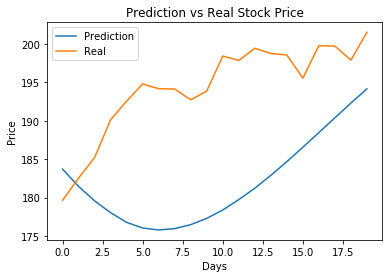

program completed  50.0 minutes :  12.0 seconds


<Figure size 432x288 with 0 Axes>

In [9]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("program completed ", stime)

In [5]:
y_pred_org[]

array([183.99374, 183.99728, 184.01501, ..., 197.87383, 197.97903,
       198.06876], dtype=float32)

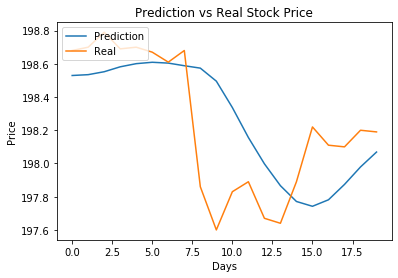

program completed  70.0 minutes :  46.0 seconds


<Figure size 432x288 with 0 Axes>

In [12]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org[-20:])
plt.plot(y_test_t_org[-20:])
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("program completed ", stime)